In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from abc import ABC, abstractmethod

class Attacker(ABC):
    def __init__(self, model, config):
        """
        ## initialization ##
        :param model: Network to attack
        :param config : configuration to init the attack
        """
        self.config = config
        self.model = model
        self.clamp = (0,1)
    
    def _random_init(self, x):
        x = x + (torch.rand(x.size(), dtype=x.dtype, device=x.device) - 0.5) * 2 * self.config['eps']
        x = torch.clamp(x,*self.clamp)
        return x

    def __call__(self, x,y):
        x_adv = self.forward(x,y)
        return x_adv


In [2]:

import torch
import torch.nn.functional as F

class FGSM(Attacker):
    def __init__(self, model, config, target=None):
        super(FGSM, self).__init__(model, config)
        self.target = target

    def forward(self, x, y):
        """
        :param x: Inputs to perturb
        :param y: Ground-truth label
        :param target : Target label 
        :return adversarial image
        """
        x_adv = x.detach().clone()

        if self.config['random_init']:
            x_adv = self._random_init(x_adv)

        x_adv.requires_grad=True
        self.model.zero_grad()

        logit = self.model(x_adv)

        if self.target is None:
            #
            cost = -F.cross_entropy(logit, y)
        else:
            cost = F.cross_entropy(logit, self.target)
        
        if x_adv.grad is not None:
            x_adv.grad.data.fill_(0)
        cost.backward()

        x_adv.grad.sign_()
        x_adv = x_adv - self.config['eps']*x_adv.grad
        x_adv = torch.clamp(x_adv,*self.clamp)

        return x_adv

In [3]:

import torch
import torch.nn.functional as F

class PGD(Attacker):
    def __init__(self, model, config, target=None):
        super(PGD, self).__init__(model, config)
        self.target = target

    def forward(self, x, y):
        """
        :param x: Inputs to perturb
        :param y: Ground-truth label
        :param target : Target label 
        :return adversarial image
        """
        x_adv = x.detach().clone()
        if self.config['random_init'] :
            x_adv = self._random_init(x_adv)
        for _ in range(self.config['attack_steps']):
            x_adv.requires_grad = True
            self.model.zero_grad()
            logits = self.model(x_adv) #f(T((x))
            if self.target is None:
                # Untargeted attacks - gradient ascent
                
                loss = F.cross_entropy(logits, y,  reduction="sum")
                loss.backward()                      
                grad = x_adv.grad.detach()
                grad = grad.sign()
                x_adv = x_adv + self.config['attack_lr'] * grad
            else:
                # Targeted attacks - gradient descent
                assert self.target.size() == y.size()           
                loss = F.cross_entropy(logits, self.target)
                loss.backward()
                grad = x_adv.grad.detach()
                grad = grad.sign()
                x_adv = x_adv - self.config['attack_lr'] * grad

            # Projection
            x_adv = x + torch.clamp(x_adv - x, min=-self.config['eps'], max=self.config['eps'])
            x_adv = x_adv.detach()
            x_adv = torch.clamp(x_adv, *self.clamp)

        return x_adv

In [4]:
!pip install -U --no-cache-dir gdown --pre
# https://drive.google.com/file/d/1kY80uzb_pGtG9rZu6N9yUDw5bYll4Rrh/view?usp=share_link
!gdown 1kY80uzb_pGtG9rZu6N9yUDw5bYll4Rrh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1kY80uzb_pGtG9rZu6N9yUDw5bYll4Rrh
To: /content/best.pt
100% 14.5M/14.5M [00:00<00:00, 43.3MB/s]


In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms


from PIL import Image

In [6]:
model = torch.hub.load('ultralytics/yolov5', 'custom', 'best.pt')  # custom/local model


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirements "gitpython>=3.1.30" "setuptools>=65.5.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0

requirements: 2 packages updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2023-3-5 Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157

In [7]:
model

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [8]:
model_fgsm = FGSM(model=model,config='random_init')

In [9]:
model_pgd = PGD(model=model,config='random_init')

In [10]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1097, done.
remote: Total 1097 (delta 0), reused 0 (delta 0), pack-reused 1097
Receiving objects: 100% (1097/1097), 110.16 MiB | 30.95 MiB/s, done.
Resolving deltas: 100% (609/609), done.


In [11]:
!ls

best.pt  pytorch-grad-cam  sample_data


In [12]:
%cd pytorch-grad-cam/

/content/pytorch-grad-cam


In [13]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
!pwd

/content/pytorch-grad-cam


In [33]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, "Stop Sign", (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img



In [90]:

image_url = "https://dl3.pushbulletusercontent.com/kYP8814A7tLPpud6Ne6losYxXZoN0PzR/00033_00009_00002_png_jpg.rf.9830ad7d08bfc1c6c22559eaa1dcc4f4.jpg"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)


In [91]:
model_pgd.model

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

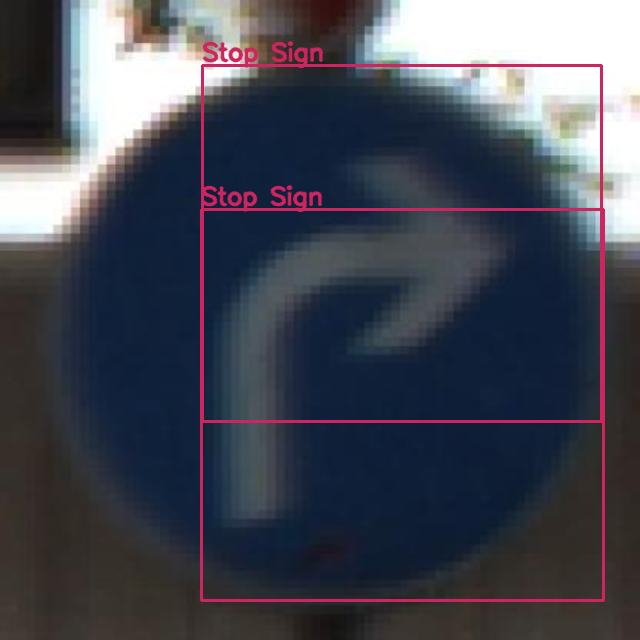

In [92]:

model = model_pgd.model
model.eval()
model.cpu()
target_layers = [model.model.model.model[-3]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

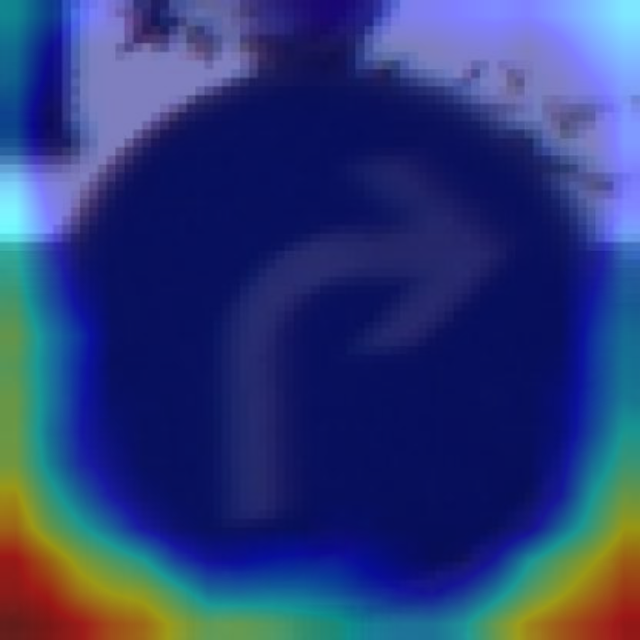

In [93]:
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

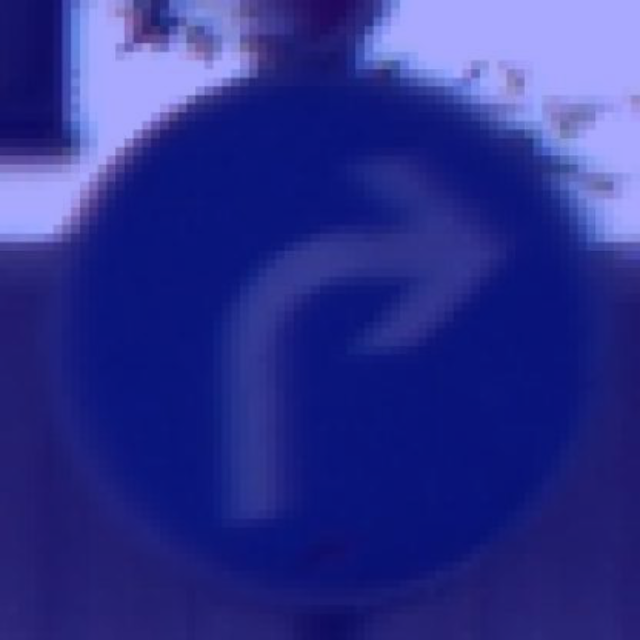

In [94]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    # for x1, y1, x2, y2 in boxes:
        # renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    names = ""
    boxes = []
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)

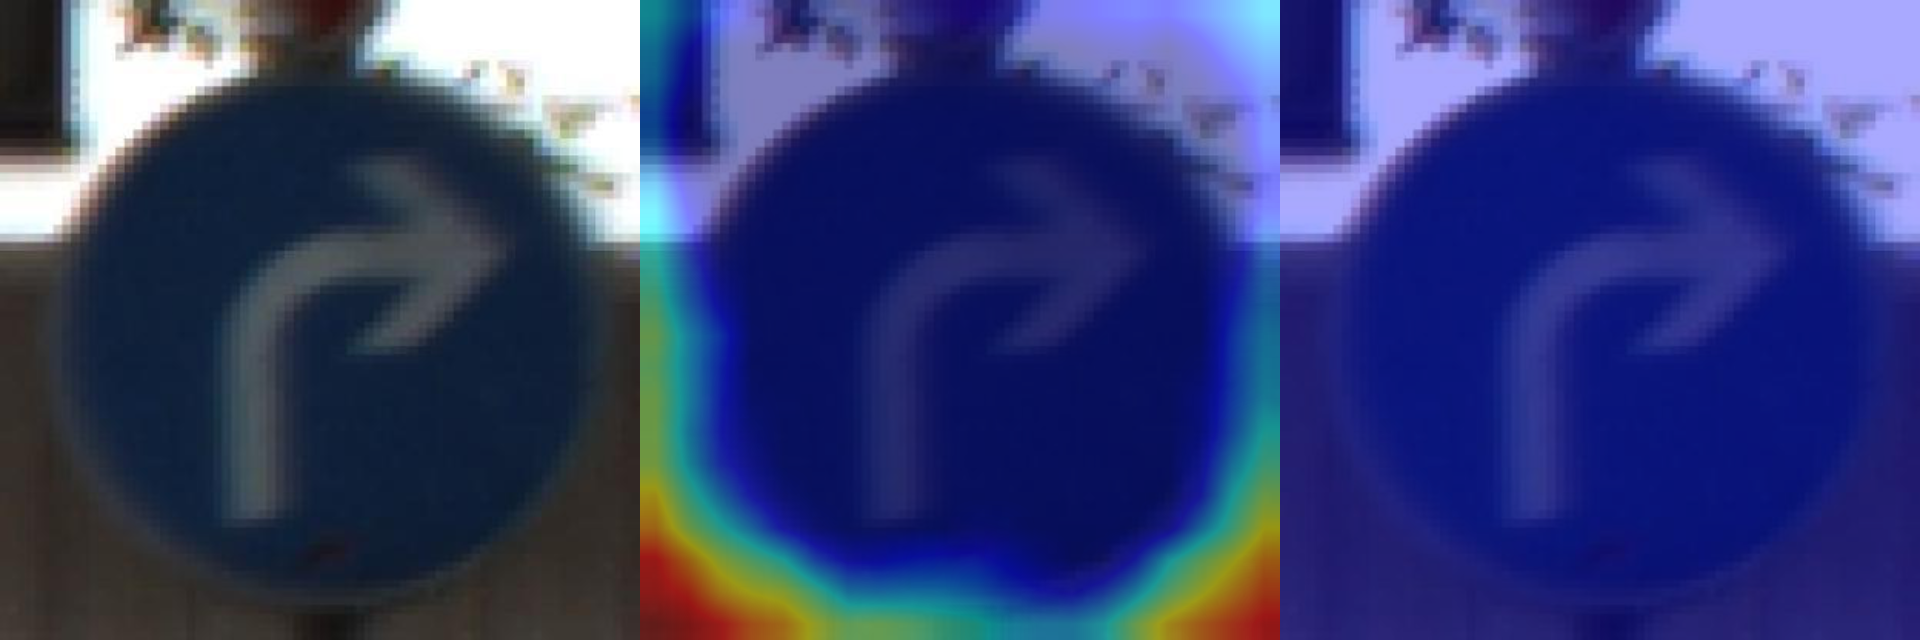

In [95]:
Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))
